In [2]:
# Install packages (if not already installed in Colab)
!pip install imbalanced-learn shap

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# For model explainability
import shap

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Load dataset (replace path if using Google Drive)
file_path = "/content/Insurance fraud dataset.xlsx"   # <-- Upload file in Colab first
df = pd.read_excel(file_path, sheet_name="Fraud_Detection_decsion tree")

# Display dataset info
print("Shape:", df.shape)
print(df.head())


Shape: (1000, 39)
   months_as_customer  age  policy_number policy_bind_date policy_state  \
0                 328   48         521585       2014-10-17           OH   
1                 228   42         342868       2006-06-27           IN   
2                 134   29         687698       2000-09-06           OH   
3                 256   41         227811       1990-05-25           IL   
4                 228   44         367455       2014-06-06           IL   

  policy_csl  policy_deductable  policy_annual_premium  umbrella_limit  \
0    250/500               1000                1406.91               0   
1    250/500               2000                1197.22         5000000   
2    100/300               2000                1413.14         5000000   
3    250/500               2000                1415.74         6000000   
4   500/1000               1000                1583.91         6000000   

   insured_zip  ... witnesses police_report_available total_claim_amount  \
0       46

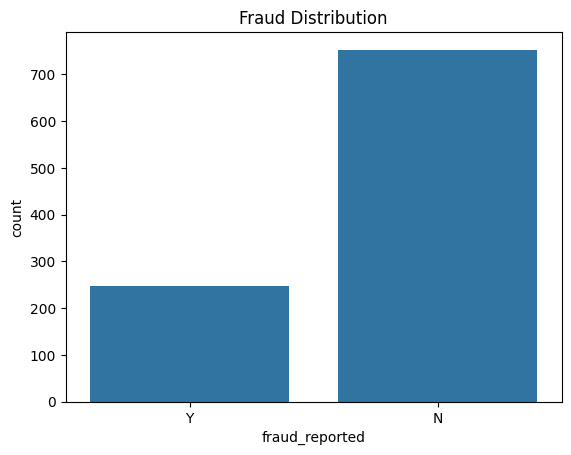

Fraud Reported Distribution (%):
 fraud_reported
N    75.3
Y    24.7
Name: proportion, dtype: float64


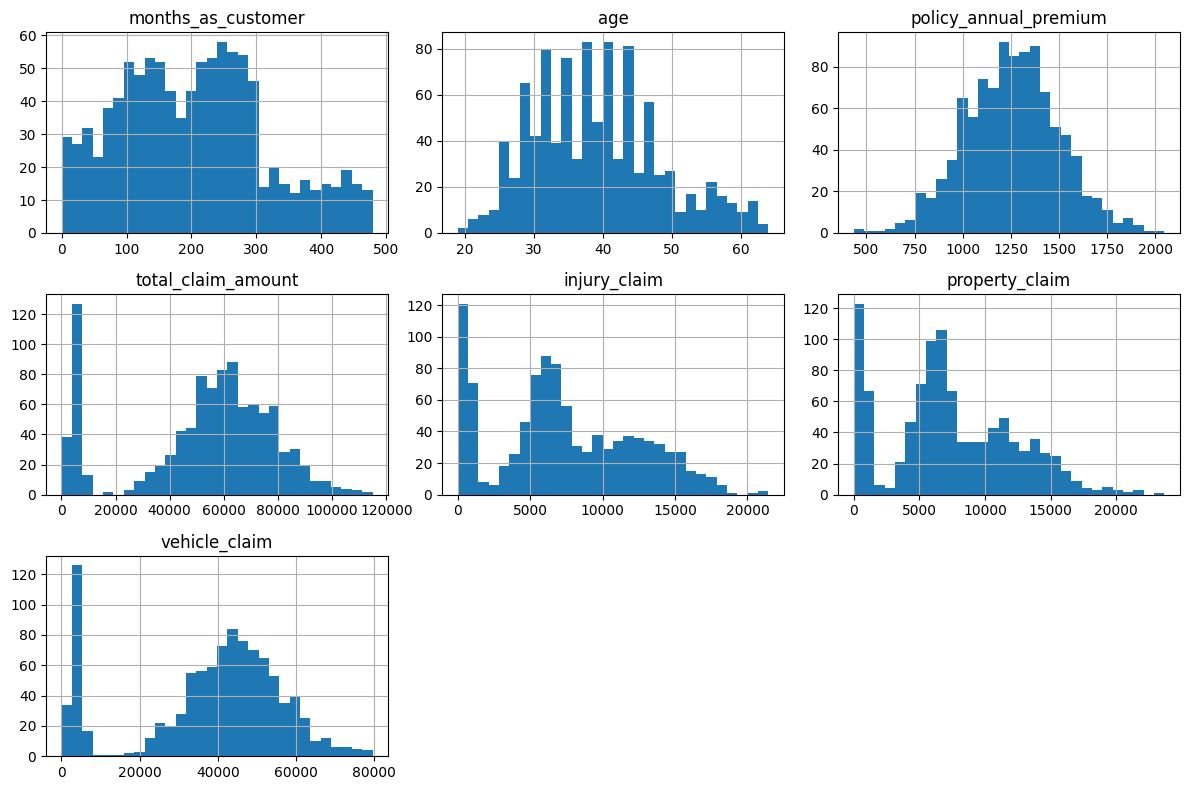

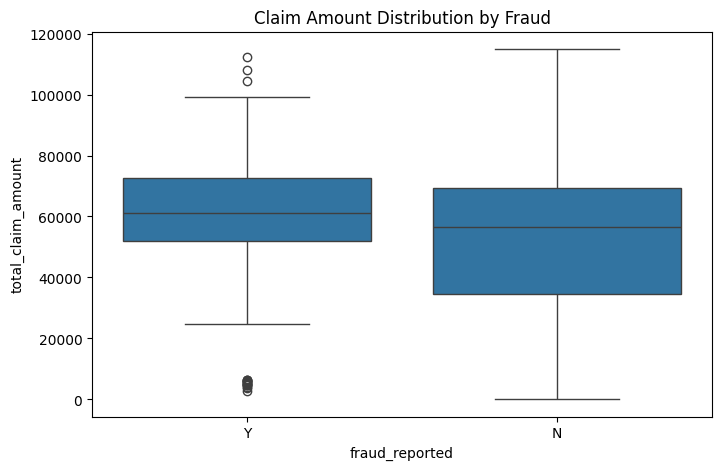

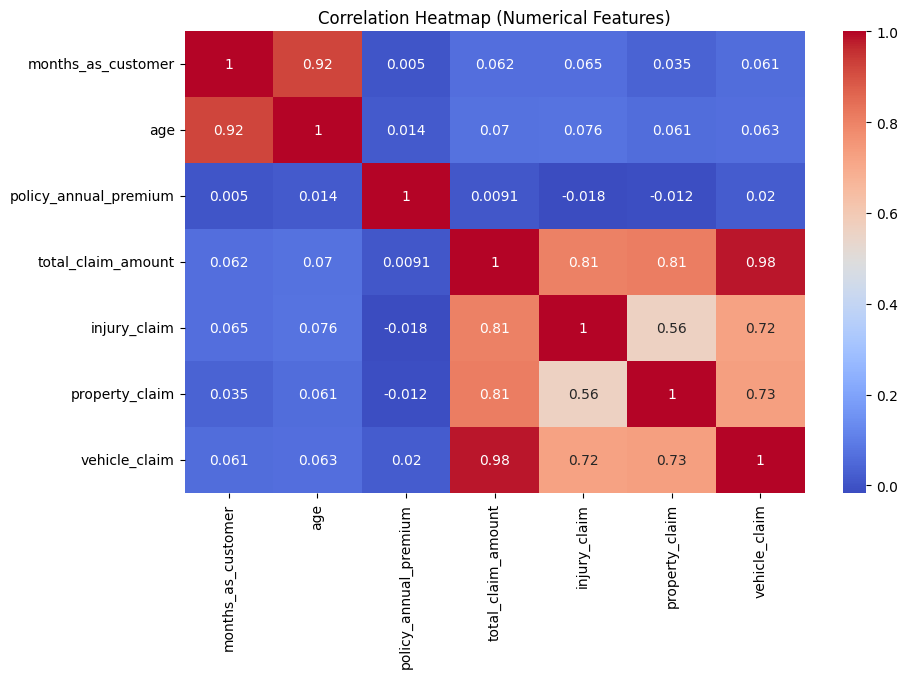

In [3]:
# Target variable distribution
sns.countplot(x='fraud_reported', data=df)
plt.title("Fraud Distribution")
plt.show()

fraud_counts = df['fraud_reported'].value_counts(normalize=True) * 100
print("Fraud Reported Distribution (%):\n", fraud_counts)

# Numerical feature distributions
num_cols = ['months_as_customer','age','policy_annual_premium',
            'total_claim_amount','injury_claim','property_claim','vehicle_claim']

df[num_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

# Boxplot for claim amounts vs fraud
plt.figure(figsize=(8,5))
sns.boxplot(x='fraud_reported', y='total_claim_amount', data=df)
plt.title("Claim Amount Distribution by Fraud")
plt.show()

# Correlation heatmap for numerical variables
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [4]:
# Drop columns that are IDs / Dates (not useful for ML)
drop_cols = ['policy_number','policy_bind_date','incident_date','incident_location']
df = df.drop(columns=drop_cols)

# Handle missing values - replace '?' with NaN
df = df.replace('?', np.nan)

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('fraud_reported')  # keep target separate

# Label encode categorical variables
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Encode target variable (Y=1, N=0)
df['fraud_reported'] = df['fraud_reported'].map({'Y':1, 'N':0})

# Features & Target
X = df.drop(columns=['fraud_reported'])
y = df['fraud_reported']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original Training Set:", X_train.shape, y_train.value_counts())
print("Resampled Training Set:", X_train_res.shape, y_train_res.value_counts())


Original Training Set: (800, 34) fraud_reported
0    602
1    198
Name: count, dtype: int64
Resampled Training Set: (1204, 34) fraud_reported
0    602
1    602
Name: count, dtype: int64


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, target_names=["Legit","Fraud"]))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))



Logistic Regression Results:
              precision    recall  f1-score   support

       Legit       0.83      0.50      0.63       151
       Fraud       0.31      0.67      0.42        49

    accuracy                           0.55       200
   macro avg       0.57      0.59      0.52       200
weighted avg       0.70      0.55      0.58       200

ROC-AUC: 0.5883903230166239

Decision Tree Results:
              precision    recall  f1-score   support

       Legit       0.92      0.85      0.88       151
       Fraud       0.62      0.78      0.69        49

    accuracy                           0.83       200
   macro avg       0.77      0.81      0.79       200
weighted avg       0.85      0.83      0.84       200

ROC-AUC: 0.8115961616434654

Random Forest Results:
              precision    recall  f1-score   support

       Legit       0.88      0.88      0.88       151
       Fraud       0.63      0.63      0.63        49

    accuracy                           0.82     

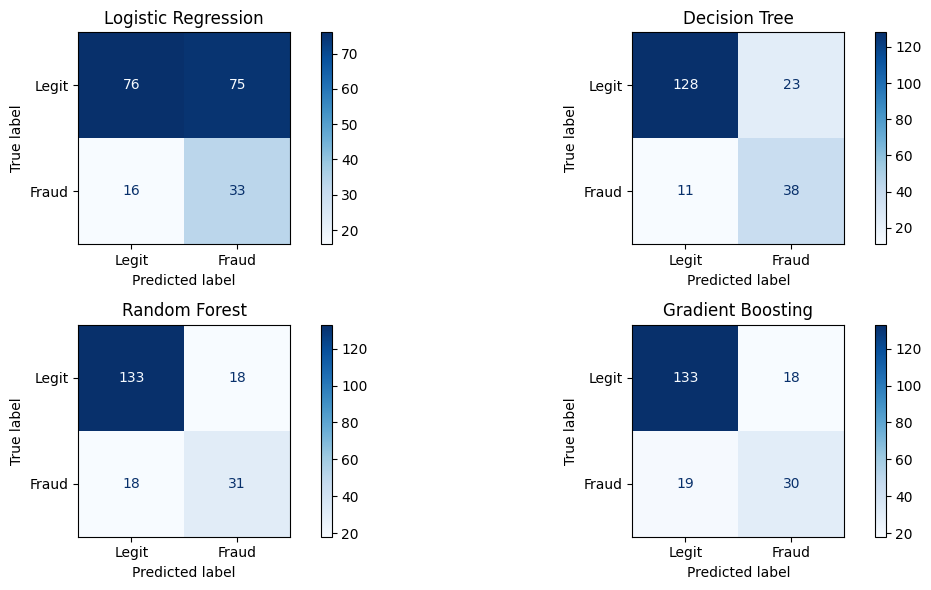

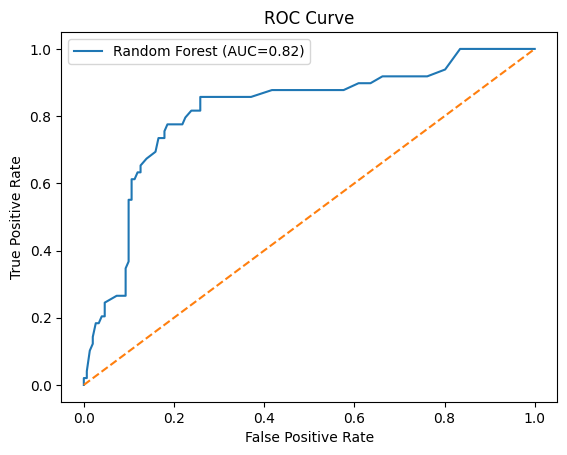

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12,6))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Legit","Fraud"], cmap="Blues", ax=plt.subplot(2,2,i))
    plt.title(name)
plt.tight_layout()
plt.show()

# ROC Curve (Random Forest example)
rf_model = models["Random Forest"]
y_probs = rf_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_score(y_test,y_probs):.2f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


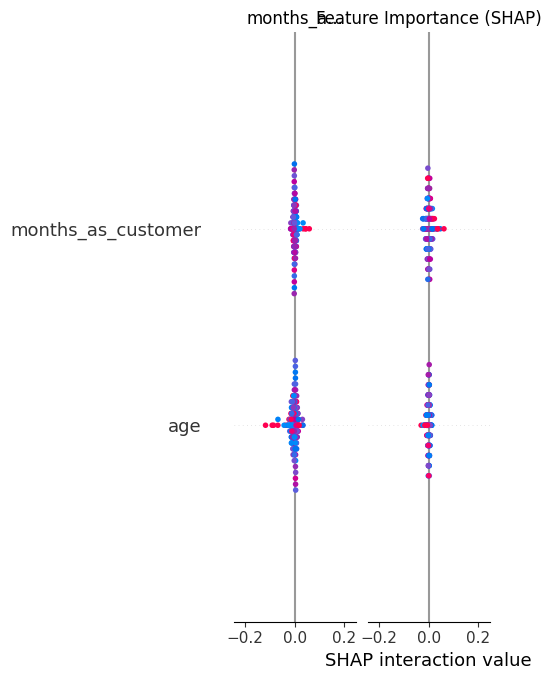

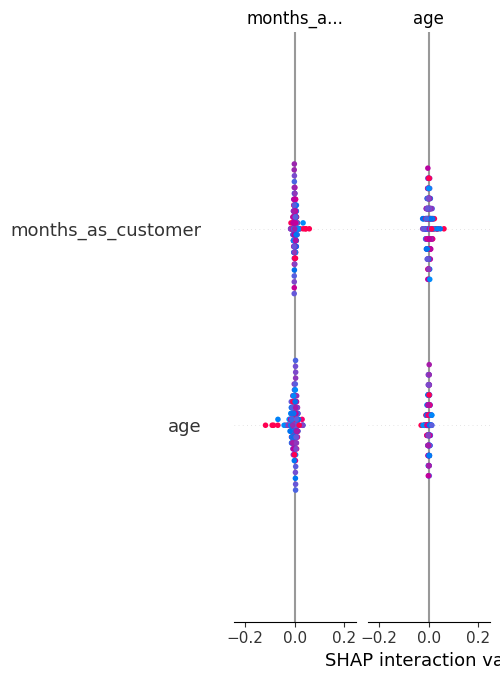

In [8]:
# SHAP Explainability for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Handle output format (list or array)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]   # Fraud class
else:
    shap_vals = shap_values      # Already correct format

# Bar summary plot
shap.summary_plot(shap_vals, X_test, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP)")
plt.show()

# Detailed beeswarm summary
shap.summary_plot(shap_vals, X_test, show=False)
plt.show()


In [10]:
results = []

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:,1]

    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": np.round(model.score(X_test, y_test), 3),
        "Precision (Fraud=1)": np.round(report["1"]["precision"], 3),
        "Recall (Fraud=1)": np.round(report["1"]["recall"], 3),
        "F1-score (Fraud=1)": np.round(report["1"]["f1-score"], 3),
        "ROC-AUC": np.round(roc_auc_score(y_test, y_probs), 3)
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision (Fraud=1)  Recall (Fraud=1)  \
0  Logistic Regression     0.545                0.306             0.673   
1        Decision Tree     0.830                0.623             0.776   
2        Random Forest     0.820                0.633             0.633   
3    Gradient Boosting     0.815                0.625             0.612   

   F1-score (Fraud=1)  ROC-AUC  
0               0.420    0.608  
1               0.691    0.819  
2               0.633    0.816  
3               0.619    0.806  


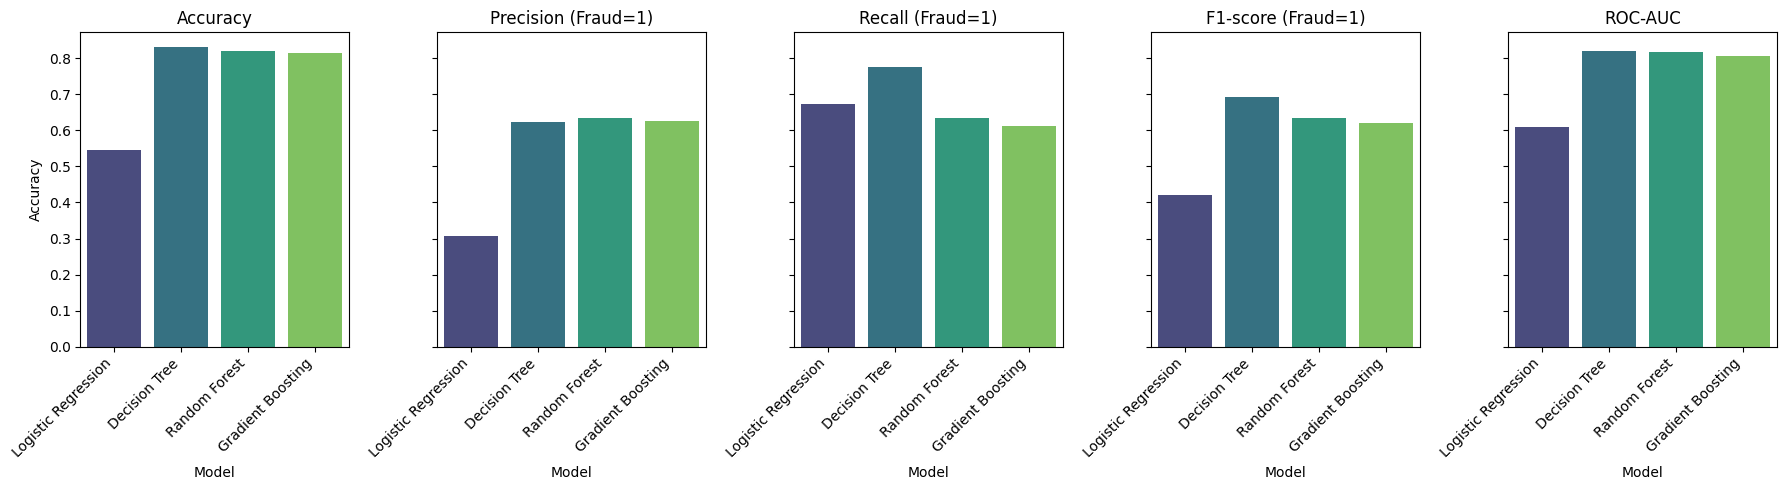

In [11]:
metrics = ["Accuracy","Precision (Fraud=1)","Recall (Fraud=1)","F1-score (Fraud=1)","ROC-AUC"]

fig, axes = plt.subplots(1, len(metrics), figsize=(18,5), sharey=True)

for i, metric in enumerate(metrics):
    sns.barplot(data=results_df, x="Model", y=metric, ax=axes[i], palette="viridis")
    axes[i].set_title(metric)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()


In [12]:
import joblib

# Final model training on resampled data
final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_train_res, y_train_res)

# Save the model
joblib.dump(final_model, "fraud_detection_rf.pkl")

print("✅ Final Random Forest model trained & saved as fraud_detection_rf.pkl")


✅ Final Random Forest model trained & saved as fraud_detection_rf.pkl


In [13]:
# Load saved model
loaded_model = joblib.load("fraud_detection_rf.pkl")

# Example: take 1 row from test set
sample = X_test.iloc[[0]]
print("Sample Claim Data:\n", sample)

# Predict fraud probability
prob = loaded_model.predict_proba(sample)[:,1][0]
prediction = loaded_model.predict(sample)[0]

print("\nFraud Probability:", round(prob*100,2), "%")
print("Prediction:", "Fraudulent" if prediction==1 else "Legitimate")


Sample Claim Data:
      months_as_customer  age  policy_state  policy_csl  policy_deductable  \
908                 285   44             2           1               2000   

     policy_annual_premium  umbrella_limit  insured_zip  insured_sex  \
908                 1144.3               0       609458            1   

     insured_education_level  ...  bodily_injuries  witnesses  \
908                        4  ...                1          0   

     police_report_available  total_claim_amount  injury_claim  \
908                        2                5500           500   

     property_claim  vehicle_claim  auto_make  auto_model  auto_year  
908             500           4500          6          10       2010  

[1 rows x 34 columns]

Fraud Probability: 20.0 %
Prediction: Legitimate


In [14]:
def predict_fraud(input_data):
    """
    input_data: Pandas DataFrame with same columns as training features
    returns: Fraud probability & prediction
    """
    model = joblib.load("fraud_detection_rf.pkl")
    prob = model.predict_proba(input_data)[:,1][0]
    pred = model.predict(input_data)[0]
    return prob, "Fraudulent" if pred==1 else "Legitimate"

# Example usage
sample = X_test.iloc[[5]]
prob, pred_label = predict_fraud(sample)
print(f"Fraud Probability: {prob:.2%}, Prediction: {pred_label}")


Fraud Probability: 23.50%, Prediction: Legitimate


🔹 Model Evaluation Metrics (Random Forest)
Accuracy      : 0.815
Precision     : 0.625
Recall        : 0.612
F1-Score      : 0.619
ROC-AUC Score : 0.815

Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.88      0.88      0.88       151
  Fraudulent       0.62      0.61      0.62        49

    accuracy                           0.81       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.81      0.81      0.81       200



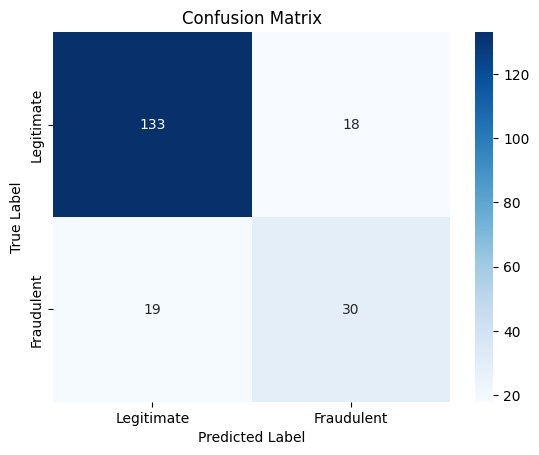

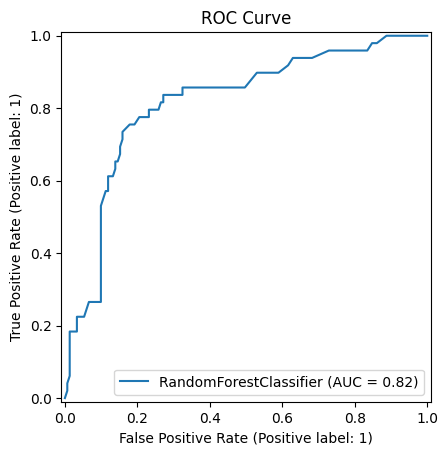

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, RocCurveDisplay

# Predict on test data
y_pred = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:,1]

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

# Print evaluation summary
print("🔹 Model Evaluation Metrics (Random Forest)")
print(f"Accuracy      : {acc:.3f}")
print(f"Precision     : {prec:.3f}")
print(f"Recall        : {rec:.3f}")
print(f"F1-Score      : {f1:.3f}")
print(f"ROC-AUC Score : {roc_auc:.3f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Legitimate","Fraudulent"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legitimate","Fraudulent"],
            yticklabels=["Legitimate","Fraudulent"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()
